In [1]:
# GPU를 사용하기 위한 GPU버전의 텐서플로우를 설치
!pip install -q tensorflow-gpu==2.0.0-rc1


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc1


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [3]:
#MNIST repository(사람 필기 이미지)를 다운로드해서 학습데이터와 검증데이터를 만든다.
# 학습데이터 : 사람의 학습문제지
# 검증데이터 : 모의고사지
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5

In [4]:
# 마지막 layer의 활성화 함수로 sigmoid(0~1) 보다 tanh(-1~1)를 더 선호합니다.
#활성화 함수 : x에 대한 y값을 찾아서 예측한 y값이 실제 y값(정답)보다 
# 크다/작다를 표시하는 함수 -> 예/아니오(1, 0)
train_images.shape

BUFFER_SIZE = 60000 # 학습용 데이터 수 
                    # (MNIST의 총 데이터가 7만개임. 학습용으로 6만개를 할당하겠다는 것임)
BATCH_SIZE = 128 # 학습시 한번에 학습할 갯수(하드웨어가 좋을 수록 크기를 크게 함)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
"""### Vanila GAN"""

# Generator 모델 작성
# G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
# Input : 100차원의 noise
# Output : Mnist 이미지 크기인 28*28
inputs = keras.Input(shape=(100,))
x = inputs
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(28*28, activation = 'tanh')(x)
outputs = layers.Reshape((28,28))(x)

In [6]:
G = keras.Model(inputs, outputs)
G.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 227,344
Trainable params: 227,344
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Discriminator 모델 작성
# D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
# Input : Mnist 이미지 (28*28)
# Output : 실제 데이터 일 확률 (0~1 사이의 값)
inputs = keras.Input(shape=(28,28))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)

D = keras.Model(inputs, outputs)
D.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 201,217
Trainable params: 201,217
Non-trainab

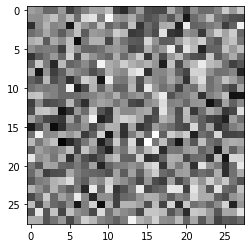

In [8]:
# 학습 전 상태로 결과를 그린다.
# 임의의 Noise를 G모델에 통과시키면 28*28 사이즈의 랜덤 이미지가 만들어집니다.
test_noise = tf.random.normal([1, 100])
fake_image_test = G(test_noise, training=False)

plt.imshow(fake_image_test[0], cmap='gray')


In [9]:
# 그리고 G모델에서 만들어진 이미지를 D모델에 통과시키면 확률이 나오게 됩니다.
decision = D(fake_image_test, training=False)
print(decision)

tf.Tensor([[-0.07262351]], shape=(1, 1), dtype=float32)


In [10]:
"""# GAN 훈련 구현
 - G모델, D모델을 훈련시킬 Loss를 생성해줍니다.
 - G모델과 D모델을 순서대로 훈련시키는 과정을 반복합니다.
"""

EPOCHS = 50
noise_dim = 100
#답안지
seed = tf.random.normal([BATCH_SIZE, noise_dim])
#지도 선생님
G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)
#비용함수(오차 검출)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [11]:
# 검증자용 채점자
def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)# 정답지
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)# 시험지
    total_loss = real_loss + fake_loss
    return total_loss #채점 결과
# 학습자용 채점자
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [12]:
# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
# 특정한 상황일때 함수를 'compile' 하여 속도가 빨라진다고 대략적으로 이해하시면 됩니다!
@tf.function
def train_step(real_images):

  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G(noises, training=True)

    real_output = D(real_images, training=True)
    fake_output = D(fake_images, training=True)

    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)

  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)# 보정값 구하기
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)# 보정값 구하기

  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))# 최적화 함수로 보정값을 적용
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))# 최적화 함수로 보정값을 적용

In [13]:
# 보정이 필요없음
def test_step(real_images):
  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  fake_images = G(noises, training=False)

  real_output = D(real_images, training=False)
  fake_output = D(fake_images, training=False)

  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)

  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [14]:
# 학습 함수

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i, image_batch in enumerate(dataset):
      train_step(image_batch)
      if i == 0:
        test_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [16]:
# Commented out IPython magic to ensure Python compatibility.
%%time
train(train_dataset, EPOCHS)

# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

noises = tf.random.normal([50, 100])
generated_image = G(noises, training=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')

plt.show()

UsageError: Line magic function `%%time` not found.


In [17]:
"""# Deep Convolutional GAN"""

# Generator 모델 작성
# G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
# Input : 100차원의 noise
# Output : Mnist 이미지 크기인 28*28
inputs = keras.Input(shape=(100,))
x = inputs
x = layers.Dense(7*7*256, use_bias=False, input_shape=(100,))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((7, 7, 256))(x)
x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
outputs = x

G = keras.Model(inputs, outputs)
G.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                   

In [18]:
# Discriminator 모델 작성
# D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
# Input : Mnist 이미지 (28*28)
# Output : 실제 데이터 일 확률 (0~1 사이의 값)
inputs = keras.Input(shape=(28,28,1))
x = inputs
x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                  input_shape=[28, 28, 1])(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(1)(x)
outputs = x

D = keras.Model(inputs, outputs)
D.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 128)         0   

In [19]:
EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [20]:

# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
# 특정한 상황일때 함수를 'compile' 하여 속도가 빨라진다고 대략적으로 이해하시면 됩니다!
@tf.function
def train_step(real_images):

  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G(noises, training=True)

    real_output = D(real_images, training=True)
    fake_output = D(fake_images, training=True)

    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)

  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)

  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

def test_step(real_images):
  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  fake_images = G(noises, training=False)

  real_output = D(real_images, training=False)
  fake_output = D(fake_images, training=False)

  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)

  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

  # 학습 함수

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i, image_batch in enumerate(dataset):
      train_step(image_batch)
      if i == 0:
        test_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [ ]:
# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
#  train_step(), test_step(), train() 동일

train(train_dataset, EPOCHS)

noises = tf.random.normal([50, 100])
generated_image = G(noises, training=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0][:,:,0], cmap='gray')
axes[0,1].imshow(generated_image[1][:,:,0], cmap='gray')
axes[1,0].imshow(generated_image[2][:,:,0], cmap='gray')
axes[1,1].imshow(generated_image[3][:,:,0], cmap='gray')
axes[2,0].imshow(generated_image[4][:,:,0], cmap='gray')
axes[2,1].imshow(generated_image[5][:,:,0], cmap='gray')

plt.show()

In [ ]:
"""# Conditional GAN
  - Mnist는 숫자 데이터이니까, 숫자 정보를 추가로 넣어줍니다.
"""

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5

num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)

train_label_onehots.shape

In [ ]:
train_label_onehots.shape

BUFFER_SIZE = 60000
BATCH_SIZE = 200

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_label_onehots)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
# Generator 모델 작성
# G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
# Input : 100차원의 noise + label
# Output : Mnist 이미지 크기인 28*28
inputs = keras.Input(shape=(100,))
conditions = keras.Input(shape=(10,))

x = layers.concatenate([inputs, conditions])
x = layers.Dense(7*7*128, use_bias=False, input_shape=(100,))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
outputs = x

G = keras.Model([inputs, conditions], outputs)
G.summary()
tf.keras.utils.plot_model(G, 'generator.png', show_shapes=True)

In [ ]:
# Discriminaotr 모델 작성
# D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
# Input : Mnist 이미지 (28*28) + label
# Output : 실제 데이터 일 확률 (0~1 사이의 값)
inputs = keras.Input(shape=(28,28,1))
conditions = keras.Input(shape=(10,))

x_c = layers.Dense(28*28)(conditions)
x_c = layers.Reshape((28,28,1))(x_c)

x = layers.concatenate([inputs,x_c])

x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(1)(x)
outputs = x

D = keras.Model([inputs,conditions], outputs)
D.summary()
tf.keras.utils.plot_model(D, 'discriminator.png', show_shapes=True)

In [ ]:
@tf.function
def train_step(real_images, real_conditions):

  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G([noises, real_conditions], training=True)

    real_output = D([real_images, real_conditions], training=True)
    fake_output = D([fake_images, real_conditions], training=True)

    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)

  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)

  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

def test_step(real_images, real_conditions):
  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  fake_images = G([noises, real_conditions], training=False)

  real_output = D([real_images, real_conditions], training=False)
  fake_output = D([fake_images, real_conditions], training=False)

  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)

  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

  return gen_loss.numpy(), dsc_loss.numpy()

In [ ]:
def plot_loss(losses) :
  plt.figure(figsize=(10,10))

  plt.plot(losses[0], label="Generator losses")
  plt.plot(losses[1], label="Discriminator losses")
  plt.xlabel("Epochs")
  plt.ylabel("Losses")
  plt.legend()
  plt.show()


In [ ]:
def train(dataset, epochs):
  gen_losses = []
  dsc_losses = []

  for epoch in range(epochs):
    start = time.time()

    for i, image_batch in enumerate(dataset):
      train_step(image_batch[0],image_batch[1])
      if i == 0:
        gen_loss, dsc_loss = test_step(image_batch[0],image_batch[1])
        gen_losses.append(gen_loss)
        dsc_losses.append(dsc_loss)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  losses = [gen_losses, dsc_losses]
  plot_loss(losses)


In [ ]:
# 학습!!!
EPOCHS = 50
import time
train(train_dataset, EPOCHS)

noises = tf.random.normal([10, 100])
labels = np.array([
                [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
                ], dtype=np.float32)
generated_image = G([noises, labels], training=False)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0][:,:,0], cmap='gray')
axes[0,1].imshow(generated_image[1][:,:,0], cmap='gray')
axes[1,0].imshow(generated_image[2][:,:,0], cmap='gray')
axes[1,1].imshow(generated_image[3][:,:,0], cmap='gray')
axes[2,0].imshow(generated_image[4][:,:,0], cmap='gray')
axes[2,1].imshow(generated_image[5][:,:,0], cmap='gray')
axes[3,0].imshow(generated_image[6][:,:,0], cmap='gray')
axes[3,1].imshow(generated_image[7][:,:,0], cmap='gray')
axes[4,0].imshow(generated_image[8][:,:,0], cmap='gray')
axes[4,1].imshow(generated_image[9][:,:,0], cmap='gray')


plt.show()